# Multi Modal Retrieval Augmented Generation

<img src="images/RAG.png" alt="Multi modal RAG Architecture" width="800"/>

<img src="images/clip.jpg" alt="CLIP (Contrastive Language–Image Pretraining)" width="800"/>

### Image souce : commons.wikimedia.org/ (Collections of the National Museum of African Art)

In [12]:
# !pip install langchain_openai
# !pip install langchain_core
# !pip install open_clip_torch
# !pip install chromadb
# !pip install matplotlib
# !pip install pillow
# !pip install pdfplumber
# !pip install nltk

In [ ]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import tqdm as notebook_tqdm

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import hashlib
import pdfplumber
from typing import List, Dict
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
image_list = []

for file_name in glob.glob("img/*.jpg"):
    image = Image.open(file_name)
    image_list.append(image)

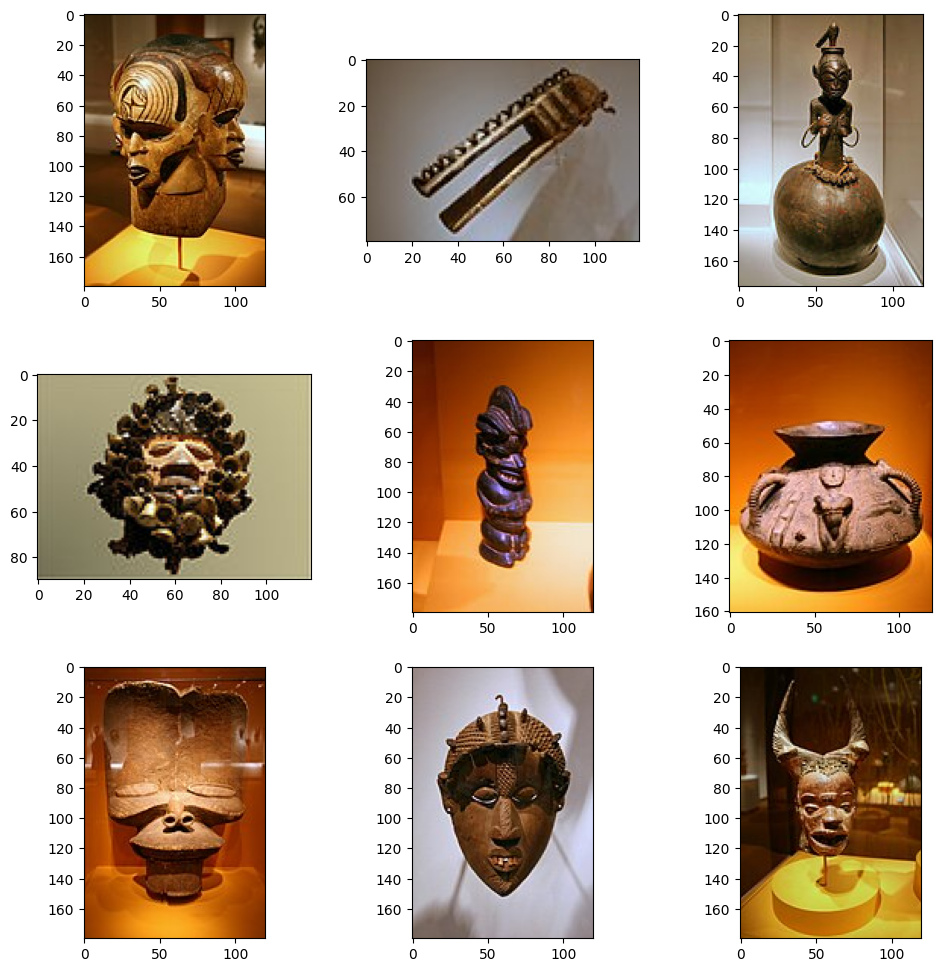

In [3]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12, 12))
img_to_show = [0, 3, 10, 22, 15, 2, 4, 8, 19]
axes = axes.flatten()

for img, ax in zip(img_to_show, axes):
   ax.imshow(image_list[img])

fig.show()

In [4]:
chromadb_client = chromadb.PersistentClient(path='Arts-store-vdb') # Create database vector

image_loader = ImageLoader()
clip_embedding_model = OpenCLIPEmbeddingFunction()
chromadb_vdb = chromadb_client.get_or_create_collection(
    name='Multimodal_arts',
    data_loader=image_loader,
    embedding_function=clip_embedding_model
    ) # Create collection (table)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def sha1_from_file(path: str) -> str:
    sha1 = hashlib.sha1()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            sha1.update(chunk)
    return sha1.hexdigest()


def sha1_from_text(text: str) -> str:
    return hashlib.sha1(text.encode("utf-8")).hexdigest()

In [6]:
print(len(os.listdir('img')))
print(len(os.listdir('Docs')))

102
102


In [7]:
images_ids = []
pdfs_ids = []
images_uris = []
pdfs_uris = []
images_folder = 'img'
pdfs_folder = 'Docs'

for index, image_name in enumerate(sorted(os.listdir(images_folder))):
    image_path = os.path.join(images_folder, image_name)
    if 'jpg' in image_name:
        pdf_path = 'Docs/' + image_name.split('.jpg')[0] + '.pdf'
    if 'jpeg' in image_name:
        pdf_path = 'Docs/' + image_name.split('.jpeg')[0] + '.pdf'
    
    images_ids.append(sha1_from_file(image_path))
    pdfs_ids.append(sha1_from_file(pdf_path))

    images_uris.append(image_path)
    pdfs_uris.append(pdf_path)

In [8]:
for i in range(5):
    print(images_ids[i], " : ", images_uris[i])

for i in range(5):
    print(pdfs_ids[i], " : ", pdfs_uris[i])

f1bb02e82687dce91addbfc1ec08ce2cd5b8cc0a  :  img/120px-Akan_female_figure_on_a_gourd.jpg
393eb3dcaf7233e7382ee8ba1d13cf14c6e610ab  :  img/120px-BamumMask.jpg
9b3028b8c2e9ebf3d64a8cecb2bc21200ad0a5e8  :  img/120px-Bwa-serpent_mask.jpg
92bd45fba4dd31375aa06c12cb41f3ab4b4689d7  :  img/120px-Chewa_jar.jpg
ccff5785d438e0997cd6c29d0934551807e4eb20  :  img/120px-Dogon_female_figure.jpg
b4da53d05caff7dea772d6d4460ca08089019b43  :  Docs/120px-Akan_female_figure_on_a_gourd.pdf
f4aeb34375ec9a6eadc0dbad27a4b6f0aab05fee  :  Docs/120px-BamumMask.pdf
e6d783ed208f624e6ab1894b286f9728fe00ca55  :  Docs/120px-Bwa-serpent_mask.pdf
6ed8003acbd5b937193dbf9437365485481342b3  :  Docs/120px-Chewa_jar.pdf
760de3f664cee40654b5c3d8fde44b5c551314b7  :  Docs/120px-Dogon_female_figure.pdf


In [11]:
class PDFProcessor:
    """
    - CLIP chunks : courts, descriptifs (pour retrieval multimodal)
    - LLM chunks  : riches, explicatifs (pour génération)
    """

    def __init__(
        self,
        clip_min_chars: int = 30,
        clip_max_chars: int = 250,
        llm_chunk_size: int = 800,
        llm_overlap: int = 100,
    ):
        self.clip_min_chars = clip_min_chars
        self.clip_max_chars = clip_max_chars
        self.llm_chunk_size = llm_chunk_size
        self.llm_overlap = llm_overlap

    # -------- TEXT EXTRACTION -------- #

    def extract_pages(self, pdf_path: str) -> List[str]:
        pages = []
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    pages.append(text)
        return pages

    # -------- CLIP CHUNKING -------- #

    def clip_chunks(self, text: str) -> List[str]:
        sentences = nltk.sent_tokenize(text)
        return [
            s.strip()
            for s in sentences
            if self.clip_min_chars <= len(s) <= self.clip_max_chars
        ]

    # -------- LLM CHUNKING -------- #

    def llm_chunks(self, text: str) -> List[str]:
        chunks = []
        start = 0
        while start < len(text):
            end = start + self.llm_chunk_size
            chunk = text[start:end]
            chunks.append(chunk.strip())
            start = end - self.llm_overlap
        return chunks

    # -------- MAIN PIPELINE -------- #

    def process(self, pdf_path: str, image_path: str):

        pdf_id = "pdf_" + sha1_from_file(pdf_path)
        image_id = "img_" + sha1_from_file(image_path)

        pages = self.extract_pages(pdf_path)

        clip_docs = []
        clip_ids = []
        clip_meta = []

        llm_chunks_store = {}  # llm_chunk_id -> texte

        for page_num, page_text in enumerate(pages, start=1):

            # 1️⃣ créer les LLM chunks
            llm_chunks = self.llm_chunks(page_text)

            for llm_idx, llm_text in enumerate(llm_chunks):
                llm_chunk_id = sha1_from_text(
                    f"{pdf_id}_p{page_num}_llm_{llm_idx}"
                )

                llm_chunks_store[llm_chunk_id] = llm_text

                # 2️⃣ CLIP chunks associés à CE LLM chunk
                for sentence in self.clip_chunks(llm_text):

                    clip_id = sha1_from_text(
                        f"{llm_chunk_id}_{sentence}"
                    )

                    clip_docs.append(sentence)
                    clip_ids.append(clip_id)
                    clip_meta.append({
                        "type": "text",
                        "pdf_id": pdf_id,
                        "image_id": image_id,
                        "page": page_num,
                        "llm_chunk_id": llm_chunk_id
                    })

        return {
            "pdf_id": pdf_id,
            "image_id": image_id,
            "clip_docs": clip_docs,
            "clip_ids": clip_ids,
            "clip_meta": clip_meta,
            "llm_chunks_store": llm_chunks_store
        }

In [12]:
pdf_pross = PDFProcessor()
pages = pdf_pross.extract_pages('Docs/120px-Dogon_female_figure.pdf')
pages

["Nom : Figure féminine\nDescription : Figure féminine , peuple Dogon, Mali, XIXe-début XXe siècle, bois,\nincrustation\nLe corps et le bouchon labial représentent une figure féminine dogon. Les têtes multiples\nsuggèrent la nature fluide des nommo, êtres spirituels primordiaux au cœur de la\ncosmologie dogon. Le disque surmontant les têtes sert de surface d'autel pour les libations.\nCe type de figure a probablement été commandé pour protéger la famille (les têtes ont le\nregard tourné dans toutes les directions) et témoigner de l'importance de l'harmonie\nfamiliale. Les points de pigment rouge, blanc et noir au dos des figures et sur le pilier\ncentral sont inhabituels. Si les masques dogon présentent des motifs peints, les figures et\nles tabourets ont généralement des surfaces incrustées ou érodées, caractéristiques d'un\nusage rituel.\nDate de prise de l’image : 21 septembre 2008\nSource : Musée national d'art africain"]

In [13]:
prosess_pdf = pdf_pross.process('Docs/120px-Dogon_female_figure.pdf', 'img/120px-Dogon_female_figure.jpg')
prosess_pdf

#len(prosess_pdf['clip_docs'])

{'pdf_id': 'pdf_760de3f664cee40654b5c3d8fde44b5c551314b7',
 'image_id': 'img_ccff5785d438e0997cd6c29d0934551807e4eb20',
 'clip_docs': ['Nom : Figure féminine\nDescription : Figure féminine , peuple Dogon, Mali, XIXe-début XXe siècle, bois,\nincrustation\nLe corps et le bouchon labial représentent une figure féminine dogon.',
  'Les têtes multiples\nsuggèrent la nature fluide des nommo, êtres spirituels primordiaux au cœur de la\ncosmologie dogon.',
  "Le disque surmontant les têtes sert de surface d'autel pour les libations.",
  "Ce type de figure a probablement été commandé pour protéger la famille (les têtes ont le\nregard tourné dans toutes les directions) et témoigner de l'importance de l'harmonie\nfamiliale.",
  'Les points de pigment rouge, blanc et noir au dos des figures et sur le pilier\ncentral sont inhabituels.',
  'Si les masques dogon présentent des motifs peints, les figures et\nles tabourets ont généralement des surfaces incrustées ou érodée',
  "t des motifs peints, les

In [9]:
chromadb_vdb.add(
    ids=images_ids,
    uris=images_uris,
    metadatas=[{
        "type": "image",
        "image_id": img_id,
        "pdf_id": pdf_id
    } for img_id, pdf_id in zip(images_ids, pdfs_ids)]
    )

In [ ]:
chromadb_vdb.add(
    ids=pdfs_ids,
    uris=images_uris,
    metadatas=[{
        "type": "image",
        "image_id": img_id,
        "pdf_id": pdf_id
    } for img_id, pdf_id in zip(images_ids, pdfs_ids)]
)

In [46]:
results = chromadb_vdb.query(query_texts=['Woman mask'], n_results=4, include=['uris', 'distances'])

results

{'ids': [['16', '99', '114', '77']],
 'embeddings': None,
 'documents': None,
 'uris': [['img/AkyeMask.jpg',
   'img/Punu-Lumbo_mask.jpg',
   'img/TsogoMask.jpg',
   'img/IdomaMask1.jpg']],
 'included': ['uris', 'distances'],
 'data': None,
 'metadatas': None,
 'distances': [[0.6961672306060791,
   0.7107272744178772,
   0.7131180167198181,
   0.715459942817688]]}

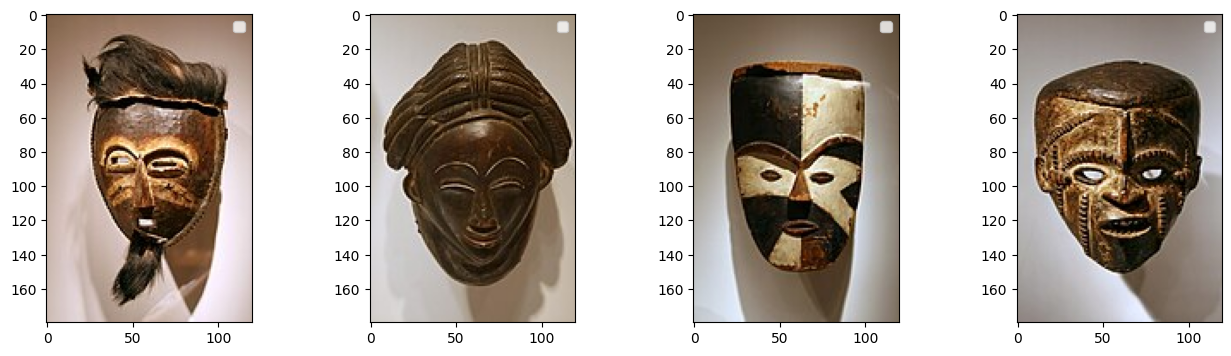

In [47]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16, 4))
img_result = results['uris'][0]
axes = axes.flatten()

for img, ax in zip(img_result, axes):
   ax.imshow(Image.open(img))
   ax.legend(results['distances'][0])

fig.show()

In [26]:
print(chromadb_vdb.count(), "images")

125 images
